In [2]:
!pip install umap-learn pytorch-metric-learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinu

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt

In [4]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def add_random_noise(image, noise_level=0.05):
    noise = torch.randn_like(image) * noise_level
    noisy_image = image + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)
    return noisy_image

transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 71616053.47it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 55.4MB/s]


In [6]:
def apply_fgsm(model, loader):
  adversarialset = []
  normalset = []

  model.eval()

  for i, data in enumerate(testloader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)
      normalset.append(inputs)

      inputs = add_random_noise(inputs)
      inputs.requires_grad = True

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      model.zero_grad()
      loss.backward()

      inputs_grad = inputs.grad.data
      perturbed_inputs = fgsm_attack(inputs, 0.1, inputs_grad)

      adversarialset.append(perturbed_inputs)

  model.train()

  return normalset, adversarialset

In [7]:
normalset, adversarialset = apply_fgsm(model, testloader)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


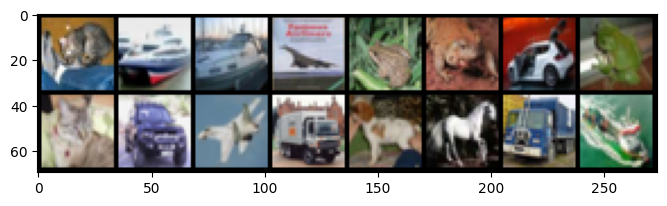

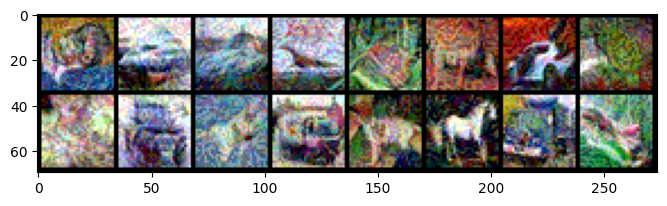

In [8]:
def imshow(img):
    plt.figure(figsize=(8, 8))
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(normalset[0][:16]))
imshow(torchvision.utils.make_grid(adversarialset[0][:16]))

In [ ]:
num_epochs = 10
losses = []

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

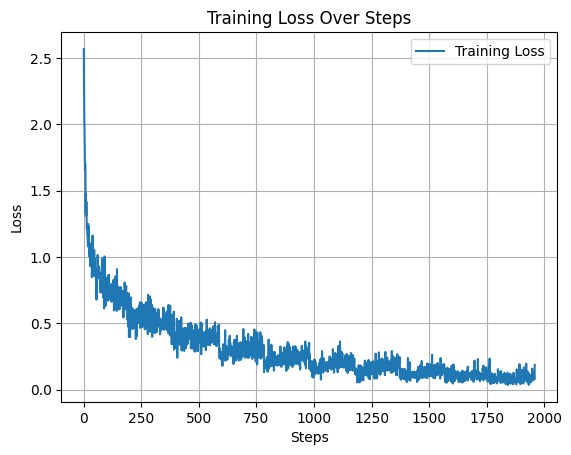

In [ ]:
plt.plot(losses, label='Training Loss')
plt.title('Training Loss Over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.grid(True) # Add a grid
plt.legend() # Add a legend
plt.show()

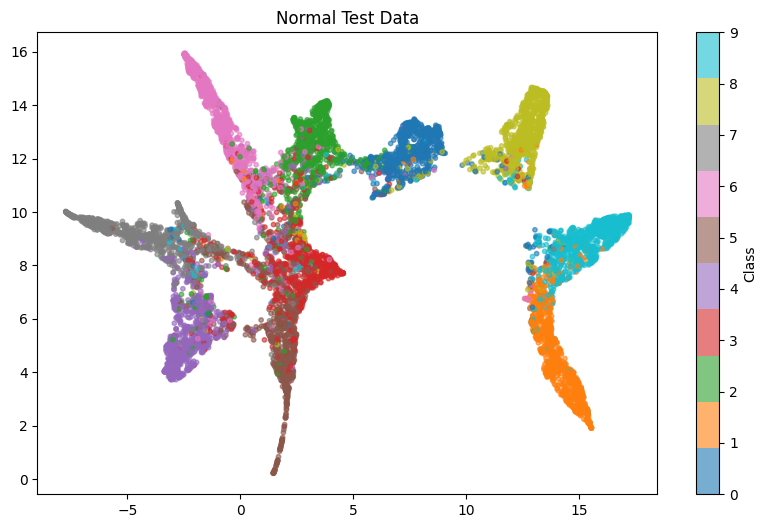

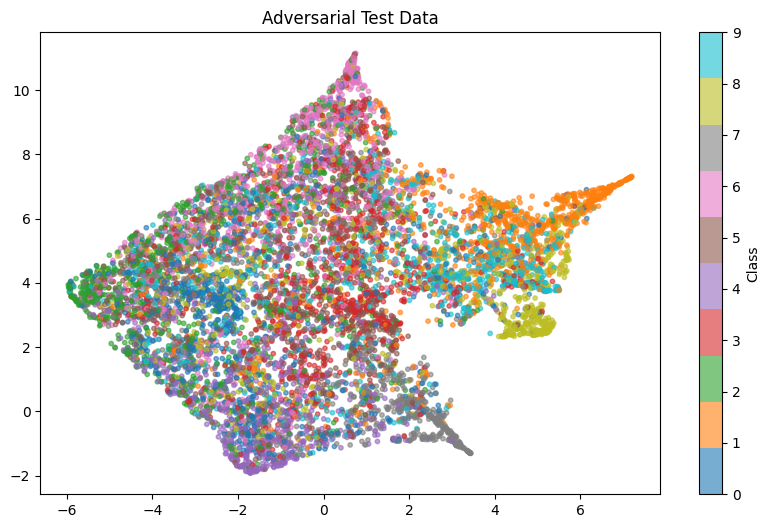

In [ ]:
from umap import UMAP
import matplotlib.pyplot as plt
import torch.nn as nn

class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.model = nn.Sequential(*list(model.children())[:-1])

    def forward(self, x):
        x = self.model(x)
        return x

feature_extractor = FeatureExtractor(model).to(device)
feature_extractor.eval()

def show_umap_dataset(dataset, title, feature_extractor):
  features = []
  labels = []

  with torch.no_grad():
      for source, data in zip(dataset, testloader):
          inputs, target = source.to(device), data[1].to(device)
          output = feature_extractor(inputs)
          output = output.view(output.size(0), -1)
          features.extend(output.cpu().detach().numpy())
          labels.extend(target.cpu().detach().numpy())

  umap = UMAP(n_components=2)
  features_reduced = umap.fit_transform(features)

  plt.figure(figsize=(10, 6))
  scatter = plt.scatter(features_reduced[:, 0], features_reduced[:, 1], c=labels, cmap='tab10', s=10, alpha=0.6)
  plt.title(title)
  plt.colorbar(scatter, label='Class')
  plt.show()

show_umap_dataset(normalset, 'Normal Test Data', feature_extractor)
show_umap_dataset(adversarialset, 'Adversarial Test Data', feature_extractor)

In [ ]:
for dataset, name in ((normalset, 'Normal'), (adversarialset, 'Adversarial')):
  correct = 0
  total = 0

  with torch.no_grad():
      for source, data in zip(dataset, testloader):
          images, labels = source.to(device), data[1].to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'{name} Accuracy: {(100 * correct / total)}')

Normal Accuracy: 81.09
Adversarial Accuracy: 33.45


# b

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)

Files already downloaded and verified


In [19]:
def apply_fgsm_batch(model, inputs, labels):
  inputs = add_random_noise(inputs)
  inputs.requires_grad = True

  outputs = model(inputs)
  loss = criterion(outputs, labels)
  model.zero_grad()
  loss.backward()

  inputs_grad = inputs.grad.data
  perturbed_inputs = fgsm_attack(inputs, 0.1, inputs_grad)

  return perturbed_inputs, labels

In [ ]:
num_epochs = 10
losses = []

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        if np.random.random() > 0.5:
          inputs, labels = apply_fgsm_batch(model, inputs, labels)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

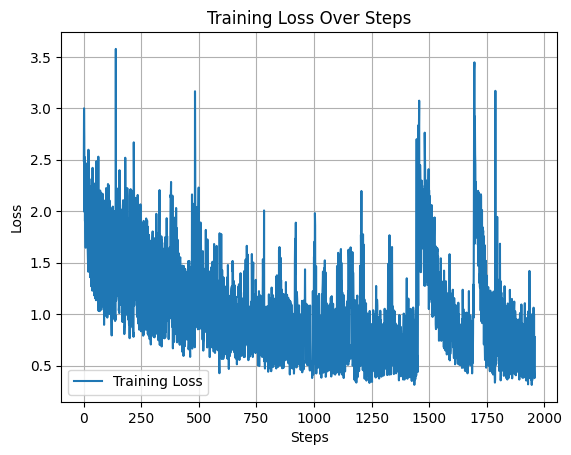

In [ ]:
plt.plot(losses, label='Training Loss')
plt.title('Training Loss Over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.grid(True) # Add a grid
plt.legend() # Add a legend
plt.show()

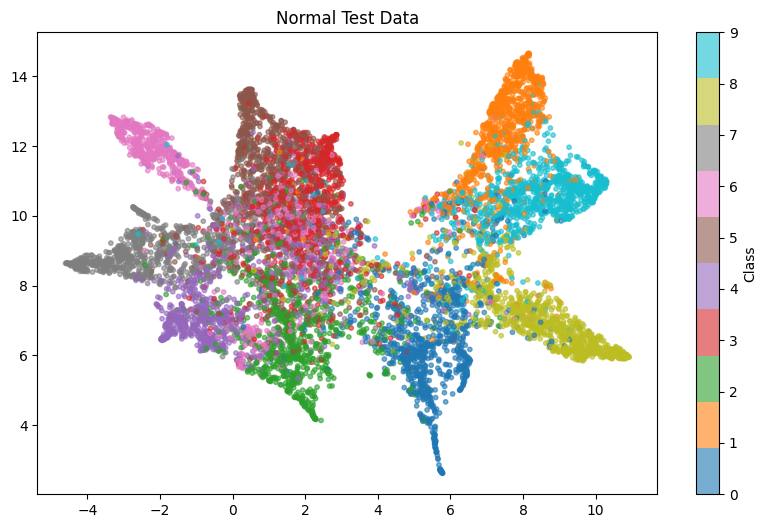

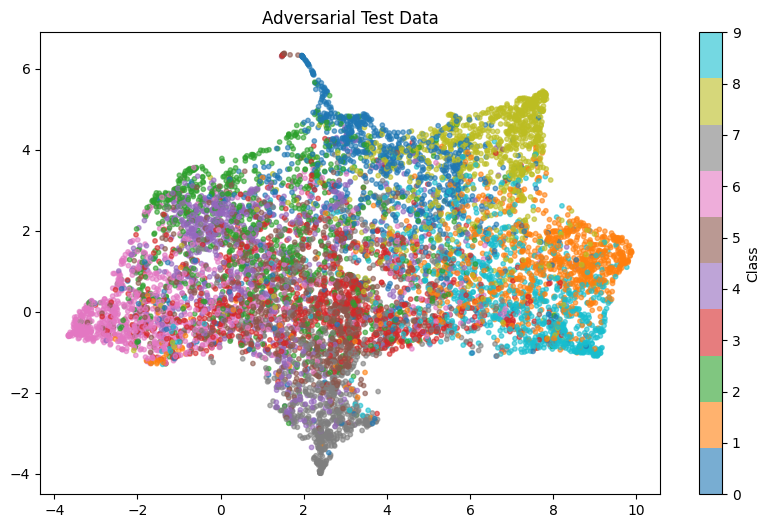

In [ ]:
feature_extractor = FeatureExtractor(model).to(device)
feature_extractor.eval()

show_umap_dataset(normalset, 'Normal Test Data', feature_extractor)
show_umap_dataset(adversarialset, 'Adversarial Test Data', feature_extractor)

In [ ]:
for dataset, name in ((normalset, 'Normal'), (adversarialset, 'Adversarial')):
  correct = 0
  total = 0

  with torch.no_grad():
      for source, data in zip(dataset, testloader):
          images, labels = source.to(device), data[1].to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'{name} Accuracy: {(100 * correct / total)}')

Normal Accuracy: 70.1
Adversarial Accuracy: 51.69
